In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import torch
import tensorflow as tf
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# from google.colab import drive
# # drive.mount('/content/drive')

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


In [ ]:
data = pd.read_csv('tripadvisor_hotel_reviews.csv')

In [ ]:
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [ ]:
data.isnull().any()

,0
Review,False
Rating,False


In [ ]:
print(data['Rating'].describe())

count    20491.000000
mean         3.952223
std          1.233030
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: Rating, dtype: float64


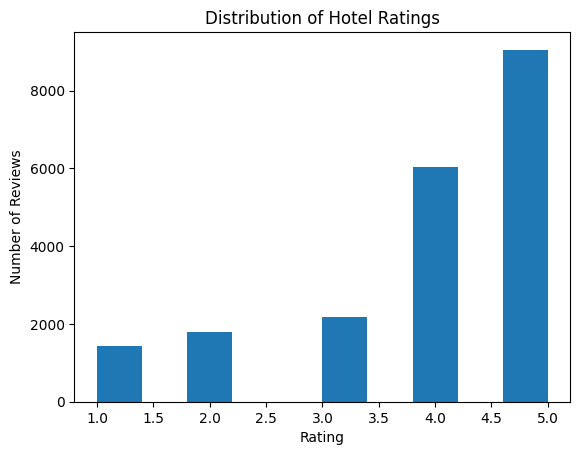

In [ ]:
rating_counts = data['Rating'].value_counts().sort_index()

plt.hist(data['Rating'])
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Hotel Ratings')
plt.show()

In [ ]:
# Define a function to map rating to sentiment
def map_to_sentiment(rating):
  if rating > 3:
    return 2  # Positive
  elif rating == 3:
    return 1  # Neutral
  else:
    return 0  # Negative

# Create a new 'sentiment' column based on the rating
data['sentiment'] = data['Rating'].apply(map_to_sentiment)

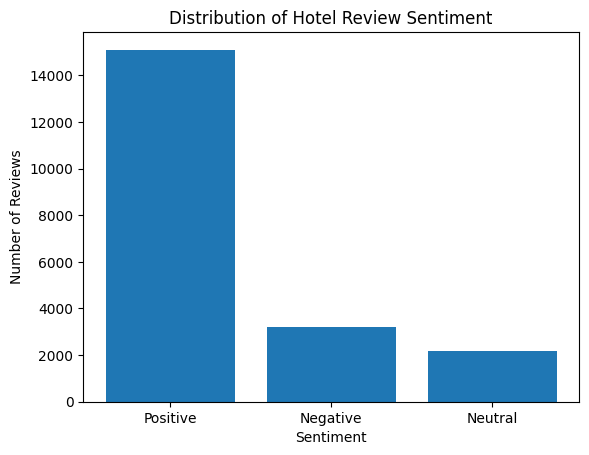

In [ ]:
# Get sentiment counts
sentiment_counts = data['sentiment'].value_counts()

# Map sentiment labels for visualization
sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
sentiment_counts = sentiment_counts.rename(sentiment_labels)

# Create a histogram to visualize sentiment distribution
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Hotel Review Sentiment')
plt.show()

In [ ]:
data.head()

,Review,Rating,sentiment
0,nice hotel expensive parking got good deal sta...,4,2
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,1
3,"unique, great stay, wonderful time hotel monac...",5,2
4,"great stay great stay, went seahawk game aweso...",5,2


In [ ]:
import re
def clean_text(text):
  """
  Cleans text by performing the following:
  - Lowercasing
  - Removing punctuation and special characters
  - Removing stop words (optional)
  """
  text = text.lower()
  text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and special characters
  # You can optionally remove stop words using libraries like NLTK
  stop_words = set(stopwords.words('english'))  # Download NLTK stopwords corpus (first run)
  filtered_words = [word for word in text.split() if word not in stop_words]
  text = " ".join(filtered_words)
  return text

In [ ]:
data['Review'] = data['Review'].apply(clean_text)
data.head()

,Review,Rating,sentiment
0,nice hotel expensive parking got good deal sta...,4,2
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms 4 experience hotel monaco seattle g...,3,1
3,unique great stay wonderful time hotel monaco ...,5,2
4,great stay great stay went seahawk game awesom...,5,2


In [ ]:
print("Loading BERT Tokenizer")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT Tokenizer


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
sentences = data.Review.values
labels = data.sentiment.values

In [ ]:
print("Original: ", sentences[0])

print("Tokenized: ", tokenizer.tokenize(sentences[0]))

print("Token IDS: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original:  nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous reviews valet parking check quick easy little disappointed nonexistent view room room clean nice size bed comfortable woke stiff neck high pillows soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway maybe noisy neighbors aveda bath products nice goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience pay 40 parking night
Tokenized:  ['nice', 'hotel', 'expensive', 'parking', 'got', 'good', 'deal', 'stay', 'hotel', 'anniversary', 'arrived', 'late', 'evening', 'took', 'advice', 'previous', 'reviews', 'valet', 'parking', 'check', 'quick', 'easy', 'little', 'disappointed', 'none', '##xi', '##sten', '##t', 'view', 'room', 'room', 'clean', 'nice', 'size', 'bed', 'comfortable', 'woke', 'stiff', 'neck', 'high', 'pillows', 'sound', '##proof', 'like', 'heard', 

In [ ]:
input_ids = []
max_length = 512  # Adjust this based on your model's maximum sequence length

for sent in sentences:
  encoded_sent = tokenizer.encode(
      sent,
      add_special_tokens = True,
      truncation=True,
      max_length=max_length
  )
  input_ids.append(encoded_sent)

print("Original: ", sentences[0])
print("Token IDs: ", input_ids[0])

Original:  nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous reviews valet parking check quick easy little disappointed nonexistent view room room clean nice size bed comfortable woke stiff neck high pillows soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway maybe noisy neighbors aveda bath products nice goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience pay 40 parking night
Token IDs:  [101, 3835, 3309, 6450, 5581, 2288, 2204, 3066, 2994, 3309, 5315, 3369, 2397, 3944, 2165, 6040, 3025, 4391, 27238, 5581, 4638, 4248, 3733, 2210, 9364, 3904, 9048, 16173, 2102, 3193, 2282, 2282, 4550, 3835, 2946, 2793, 6625, 8271, 10551, 3300, 2152, 17860, 2614, 18907, 2066, 2657, 2189, 2282, 2305, 2851, 5189, 28490, 4303, 3098, 5494, 2963, 2111, 3331, 6797, 2672, 20810, 10638, 13642, 2850, 7198, 3688, 3835, 2751, 7529, 29

In [ ]:
print("Max sentence length: ", max([len(sen) for sen in input_ids]))

Max sentence length:  512


In [ ]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 512

print("Padding/truncating all sentences to %d values" % MAX_LEN)
print('Padding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', value=0, truncating='post', padding='post')

print("Done")

Padding/truncating all sentences to 512 values
Padding token: "[PAD]", ID: 0
Done


In [ ]:
input_ids[0]

array([  101,  3835,  3309,  6450,  5581,  2288,  2204,  3066,  2994,
        3309,  5315,  3369,  2397,  3944,  2165,  6040,  3025,  4391,
       27238,  5581,  4638,  4248,  3733,  2210,  9364,  3904,  9048,
       16173,  2102,  3193,  2282,  2282,  4550,  3835,  2946,  2793,
        6625,  8271, 10551,  3300,  2152, 17860,  2614, 18907,  2066,
        2657,  2189,  2282,  2305,  2851,  5189, 28490,  4303,  3098,
        5494,  2963,  2111,  3331,  6797,  2672, 20810, 10638, 13642,
        2850,  7198,  3688,  3835,  2751,  7529,  2994,  3835,  3543,
        2579,  5056,  6595,  2936,  3295,  2307,  3788,  3292,  6023,
        3452,  3835,  3325,  3477,  2871,  5581,  2305,   102,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [ ]:
attention_mask = []

for sent in input_ids:
  att_mask = [int(token_id > 0) for token_id in sent]

  attention_mask.append(att_mask)

In [ ]:
train_input, test_input, train_labels, test_labels = train_test_split(input_ids,
                                                                      labels,
                                                                      random_state=42,
                                                                      test_size=0.2)
train_mask, test_mask, _, _ = train_test_split(attention_mask,
                                               labels,
                                               random_state=42,
                                               test_size=0.2)

train_input, validation_input, train_labels, validation_labels = train_test_split(train_input,
                                                                                  train_labels,
                                                                                  random_state=42,
                                                                                  test_size=0.2)
train_mask, validation_mask, _, _ = train_test_split(train_mask,
                                                     train_mask,
                                                     random_state=42,
                                                     test_size=0.2)

In [ ]:
print("== Train ==")
print("Input: ", train_input.shape)
print("Label: ", train_labels.shape)
print("Mask: ", np.array(train_mask).shape)

print("\n== Validation ==")
print("Input: ", validation_input.shape)
print("Label: ", validation_labels.shape)
print("Mask: ", np.array(validation_mask).shape)

print("\n== Test ==")
print("Input: ", test_input.shape)
print("Label: ", test_labels.shape)
print("Mask: ", np.array(test_mask).shape)

== Train ==
Input:  (13113, 512)
Label:  (13113,)
Mask:  (13113, 512)

== Validation ==
Input:  (3279, 512)
Label:  (3279,)
Mask:  (3279, 512)

== Test ==
Input:  (4099, 512)
Label:  (4099,)
Mask:  (4099, 512)


In [ ]:
train_input = torch.tensor(train_input)
train_labels = torch.tensor(train_labels)
train_mask = torch.tensor(train_mask)

validation_input = torch.tensor(validation_input)
validation_labels = torch.tensor(validation_labels)
validation_mask = torch.tensor(validation_mask)

test_input = torch.tensor(test_input)
test_labels = torch.tensor(test_labels)
test_mask = torch.tensor(test_mask)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_input, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_input, validation_mask, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_input, test_mask, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False
)

model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
params = list(model.named_parameters())

print("The BERT model has {:} different named parameters.".format(len(params)))

print("==== Embedding Layer ====")
for p in params[0:5]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== First Transformers ====")
for p in params[5:21]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== Output Layer ====")
for p in params[-4:]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.
==== Embedding Layer ====
bert.embeddings.word_embeddings.weight                       (30522, 768)
bert.embeddings.position_embeddings.weight                     (512, 768)
bert.embeddings.token_type_embeddings.weight                     (2, 768)
bert.embeddings.LayerNorm.weight                                   (768,)
bert.embeddings.LayerNorm.bias                                     (768,)
==== First Transformers ====
bert.encoder.layer.0.attention.self.query.weight               (768, 768)
bert.encoder.layer.0.attention.self.query.bias                     (768,)
bert.encoder.layer.0.attention.self.key.weight                 (768, 768)
bert.encoder.layer.0.attention.self.key.bias                       (768,)
bert.encoder.layer.0.attention.self.value.weight               (768, 768)
bert.encoder.layer.0.attention.self.value.bias                     (768,)
bert.encoder.layer.0.attention.output.dense.weight             (768, 768)
bert.e

In [ ]:
optimizer = AdamW(
    model.parameters(),
    lr = 2e-5,
    eps = 1e-8
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 5

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                             num_warmup_steps = 0,
                                             num_training_steps = total_steps)

In [ ]:
def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights using the stratified training set
train_labels_array = np.array(train_labels)
class_weights = compute_class_weight(class_weight='balanced', classes = np.unique(train_labels_array), y = train_labels_array)
class_weight_dict = dict(enumerate(class_weights))

Training BERT

In [ ]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range(0, epochs):

  # ===================================
  #              Training
  # ===================================

  print("======= Epoch {:} / {:} =======".format(epoch_i+1, epochs))
  print("Training...")

  t0 = time.time()

  total_loss = 0

  model.train()

  # For each batch of training data
  for step, batch in enumerate(train_dataloader):

    # Progress update every 40 batches
    if step % 40 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)

      print("Batch {:>5,} of {:>5,}.     Elapsed: {:}".format(step, len(train_dataloader), elapsed))

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad()

    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

    loss = outputs[0]

    if class_weight_dict:
            weights = torch.tensor([class_weight_dict[t.item()] for t in b_labels], dtype=torch.float, device=device)
            loss = (loss * weights).mean()

    total_loss += loss.item()

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    scheduler.step()

  avg_train_loss = total_loss / len(train_dataloader)

  loss_values.append(avg_train_loss)

  print("   Average training loss: {0:.2f}".format(avg_train_loss))
  print("   Training epoch took: {:}".format(format_time(time.time() - t0)))

  # ===================================
  #             Validation
  # ===================================

  print("Running Validation...")

  t0 = time.time()

  model.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in validation_dataloader:

    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy

    nb_eval_steps += 1

  print("   Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
  print("   Validation took: {:}".format(format_time(time.time() - t0)))

print("Training complete!")

======= Epoch 1 / 5 =======
Training...
Batch    40 of   410.     Elapsed: 0:01:50
Batch    80 of   410.     Elapsed: 0:03:45
Batch   120 of   410.     Elapsed: 0:05:40
Batch   160 of   410.     Elapsed: 0:07:35
Batch   200 of   410.     Elapsed: 0:09:30
Batch   240 of   410.     Elapsed: 0:11:24
Batch   280 of   410.     Elapsed: 0:13:19
Batch   320 of   410.     Elapsed: 0:15:14
Batch   360 of   410.     Elapsed: 0:17:09
Batch   400 of   410.     Elapsed: 0:19:04
   Average training loss: 0.45
   Training epoch took: 0:19:32
Running Validation...
   Accuracy: 0.86
   Validation took: 0:01:39
======= Epoch 2 / 5 =======
Training...
Batch    40 of   410.     Elapsed: 0:01:55
Batch    80 of   410.     Elapsed: 0:03:50
Batch   120 of   410.     Elapsed: 0:05:44
Batch   160 of   410.     Elapsed: 0:07:39
Batch   200 of   410.     Elapsed: 0:09:34
Batch   240 of   410.     Elapsed: 0:11:29
Batch   280 of   410.     Elapsed: 0:13:23
Batch   320 of   410.     Elapsed: 0:15:18
Batch   360 of 

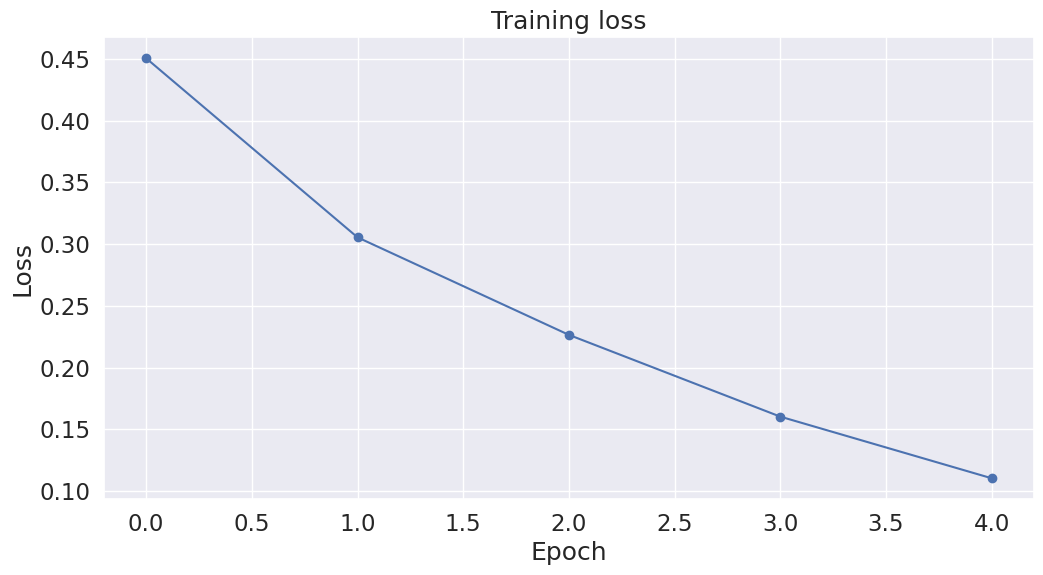

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:
print("Predicting labels for {:,} test sentences".format(len(test_input)))

model.eval()

prediction, true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  prediction.append(logits)
  true_labels.append(label_ids)

print(" DONE.")

Predicting labels for 4,099 test sentences
 DONE.


In [ ]:
from sklearn.metrics import matthews_corrcoef

flat_prediction = [item for sublist in prediction for item in sublist]
flat_prediction = np.argmax(flat_prediction, axis=1).flatten()

flat_true_labels = [item for sublist in true_labels for item in sublist]

mcc = matthews_corrcoef(flat_true_labels, flat_prediction)

print("MCC: %.3f" %mcc)

MCC: 0.689


In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(flat_true_labels, flat_prediction)

print("ACC: %.4f" %acc)

ACC: 0.8712


Classification Report:
              precision    recall  f1-score   support

           0     0.8064    0.8064    0.8064       625
           1     0.4567    0.4514    0.4540       432
           2     0.9426    0.9441    0.9433      3042

    accuracy                         0.8712      4099
   macro avg     0.7352    0.7340    0.7346      4099
weighted avg     0.8706    0.8712    0.8709      4099


Confusion Matrix:
[[ 504   91   30]
 [  92  195  145]
 [  29  141 2872]]


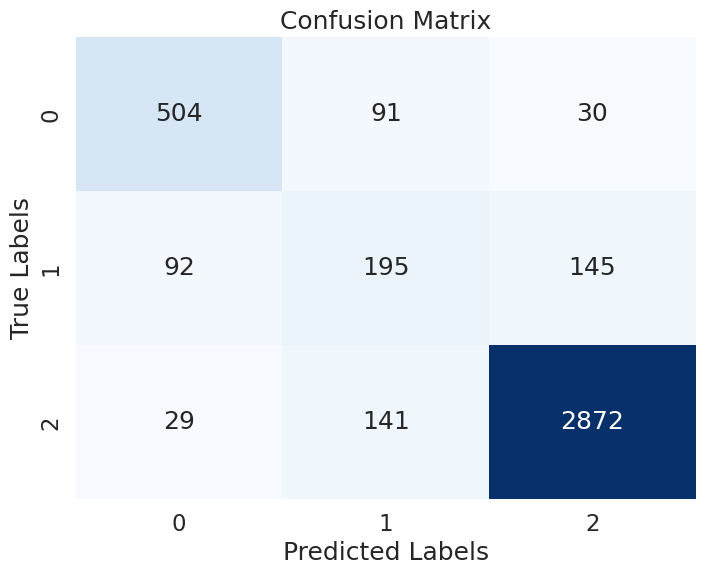

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt

# Generate classification report
class_report = classification_report(flat_true_labels, flat_prediction, digits=4)
print("Classification Report:")
print(class_report)

# Generate confusion matrix
conf_matrix = confusion_matrix(flat_true_labels, flat_prediction)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sb.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
